In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image
from IPython.display import display, HTML
import base64

In [7]:
# Base project path
BASE_DIR = "/projects/qb36/lontar_project"
DATA_DIR = os.path.join(BASE_DIR, "data")

train_file = os.path.join(DATA_DIR, 'balinese_transliteration_train.txt')
test_file = os.path.join(DATA_DIR, 'balinese_transliteration_test.txt')
image_dir = os.path.join(DATA_DIR, 'balinese_word_train')

# Load the dataset
def load_data(file_path):
    filenames = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split(';') if ';' in line else line.strip().split('\t')
            if len(parts) == 2:
                filenames.append(parts[0].strip())
                labels.append(parts[1].strip())
            else:
                print(f"Skipping malformed line: {line}")

    return pd.DataFrame({'filename': filenames, 'label': labels})

# Load both training and testing datasets
train_df = load_data(train_file)
test_df = load_data(test_file)

# Display dataset information
print("Training Data Sample:")
display(train_df.head())

print("\nTesting Data Sample:")
display(test_df.head())

print("\nTraining Set Shape:", train_df.shape)
print("Testing Set Shape:", test_df.shape)

Training Data Sample:


,filename,label
0,train1.png,kagastu
1,train2.png,","
2,train3.png,gelak
3,train4.png,ancak
4,train5.png,","



Testing Data Sample:


,filename,label
0,test1.png,","
1,test2.png,biakta
2,test3.png,ngantah
3,test4.png,sarira
4,test5.png,yu



Training Set Shape: (15022, 2)
Testing Set Shape: (10475, 2)


In [8]:
# Unique transliterations
unique_translations = train_df['label'].nunique()
print(f"Total Unique Transliteration Words: {unique_translations}")

# Frequency counts
label_counts = train_df['label'].value_counts()

# Words appearing only once and less than 3 times
words_once = (label_counts == 1).sum()
words_less_than_3 = (label_counts < 3).sum()
percentage_once = (words_once / unique_translations) * 100
percentage_less_3 = (words_less_than_3 / unique_translations) * 100

print(f"Words appearing only once: {words_once} ({percentage_once:.2f}%)")
print(f"Words appearing less than 3 times: {words_less_than_3} ({percentage_less_3:.2f}%)")

# Most frequent words
print("\nTop 5 Most Frequent Words:")
display(label_counts.head(5))

# Least frequent words
print("\nBottom 5 Least Frequent Words:")
display(label_counts.tail(5))


Total Unique Transliteration Words: 4745
Words appearing only once: 3339 (70.37%)
Words appearing less than 3 times: 3961 (83.48%)

Top 5 Most Frequent Words:


label
,       3065
.        461
ring     223
nga      212
sang     151
Name: count, dtype: int64


Bottom 5 Least Frequent Words:


label
truju       1
bwa         1
kramania    1
kalinan     1
ngopita     1
Name: count, dtype: int64

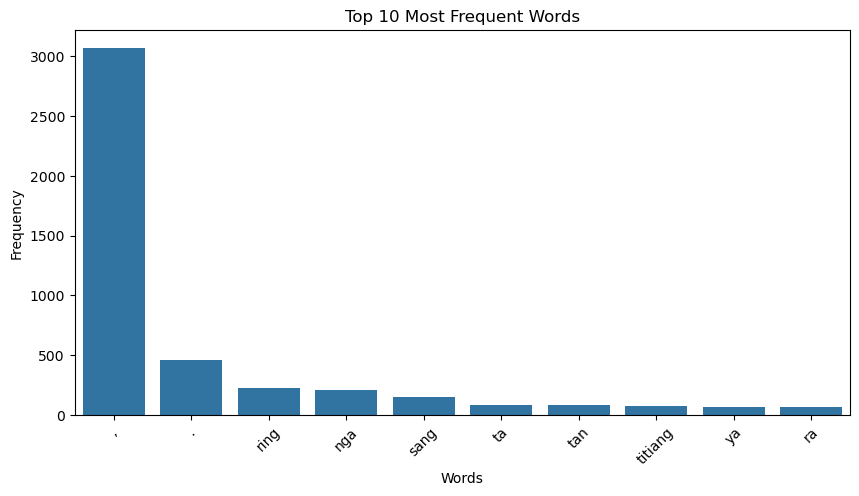

In [9]:
# Bar chart of the top 10 most frequent words
plt.figure(figsize=(10, 5))
sns.barplot(x=label_counts.head(10).index, y=label_counts.head(10).values)
plt.title("Top 10 Most Frequent Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()



Unique Characters in Training Set: ,-.0123456789ABCDEGIJKLMNOPRSTUWabcdeghijklmnoprstuwyË
Unique Characters in Testing Set: ,-.0123456789ABCDEGHIJKLMNOPRSTUWabcdeghijklmnoprstuwy


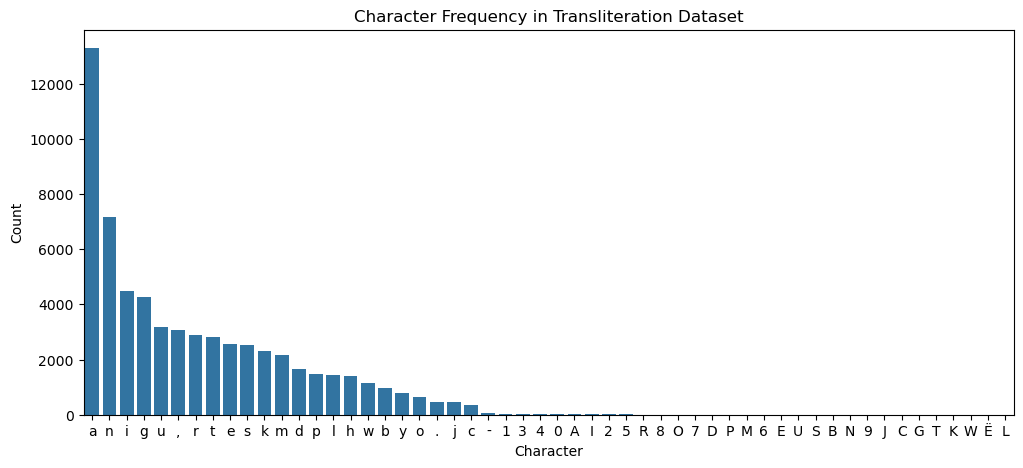

In [10]:
# Extract all unique characters in training and testing sets
train_chars = set("".join(train_df['label']))
test_chars = set("".join(test_df['label']))

# Count character occurrences
char_counts = Counter("".join(train_df['label']))
char_df = pd.DataFrame(char_counts.items(), columns=['Character', 'Count']).sort_values(by="Count", ascending=False)

print("\nUnique Characters in Training Set:", "".join(sorted(train_chars)))
print("Unique Characters in Testing Set:", "".join(sorted(test_chars)))

# Bar plot of character frequencies
plt.figure(figsize=(12, 5))
sns.barplot(x=char_df["Character"], y=char_df["Count"])
plt.title("Character Frequency in Transliteration Dataset")
plt.xlabel("Character")
plt.ylabel("Count")
plt.show()


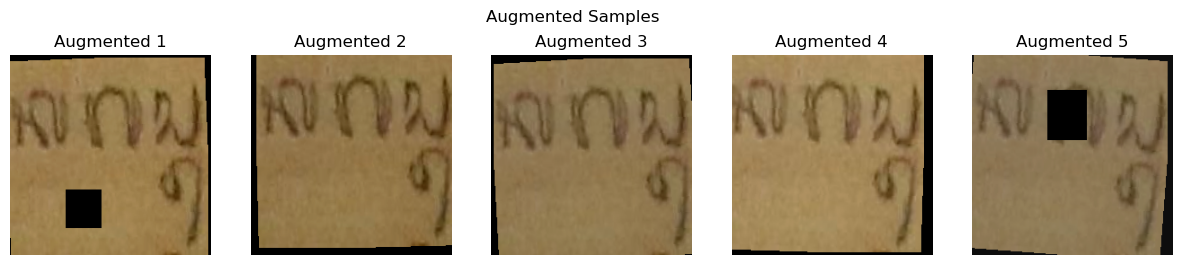

In [11]:
import torch
from torchvision import transforms
from torchvision.transforms import functional as TF
import random

# Define the same augmentation pipeline as your training transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=5),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.01, 0.05), ratio=(0.3, 3.3)),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

# Helper function to unnormalize and convert tensor to displayable image
def unnormalize(tensor):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)):
        t.mul_(s).add_(m)
    return transforms.ToPILImage()(tensor)

# Function to show mutiple augmented versions of one image
def show_augmented_samples(image_path, transform, n_samples=5):
    original_image = Image.open(image_path).convert('RGB')
    plt.figure(figsize=(15, 3))
    for i in range(n_samples):
        augmented = transform(original_image)
        augmented_image = unnormalize(augmented)
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(augmented_image)
        plt.title(f"Augmented {i+1}")
        plt.axis('off')
    plt.suptitle("Augmented Samples")
    plt.show()

# Select one sample image to test augmentation
sample_image_name = train_df.iloc[0]['filename']
sample_image_path = os.path.join(image_dir, sample_image_name)

# Show the augmented images
show_augmented_samples(sample_image_path, train_transform)

Sample shown: train10556.png — Label: nga


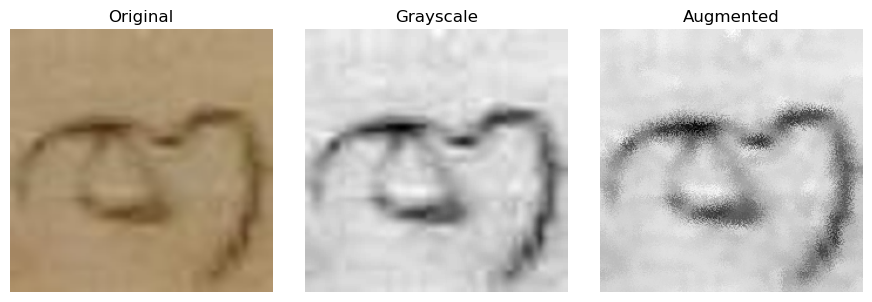

In [75]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import numpy as np

from augmentations.script_level.Information_extraction import information_extraction
from augmentations.script_level.transformation import flag_judge, identify_reference_corner
from augmentations.script_level.transformation import bezier_transformation, affine_transformation, L2A_transformation
from augmentations.script_level import script_aug
from augmentations.script_level.script_aug import new_local

# Updated ScriptLevelAugment class with debug and resizing
class ScriptLevelAugment:
    def __init__(self, prob=1.0, stroke_radius=1, 
                 k1_control_field_corner=0.3, 
                 k2_control_field_third_bezier=0.3, 
                 segment=3, debug=False, output_size=(224, 224)):
        self.prob = prob
        self.stroke_radius = stroke_radius
        self.k1_control_field_corner = k1_control_field_corner
        self.k2_control_field_third_bezier = k2_control_field_third_bezier
        self.segment = segment
        self.debug = debug
        self.output_size = output_size

    def __call__(self, pil_img):
        from augmentations.script_level.script_aug import new_local

        if random.random() > self.prob:
            return pil_img.resize(self.output_size)

        img = np.array(pil_img.convert("RGB"))
        aug_imgs = new_local(
            img, 
            times=1,
            stroke_radius=self.stroke_radius,
            k1_control_field_corner=self.k1_control_field_corner,
            k2_control_field_third_bezier=self.k2_control_field_third_bezier,
            segment=self.segment
        )

        if not aug_imgs or not isinstance(aug_imgs[0], np.ndarray):
            return pil_img.resize(self.output_size)

        if self.debug:
            plt.imshow(aug_imgs[0])
            plt.title("Raw Augmented Output from new_local()")
            plt.axis('off')
            plt.show()

        # Resize for better visibility
        return Image.fromarray(aug_imgs[0].astype(np.uint8)).convert("RGB").resize(self.output_size)

# Transform with resizing to 224x224 and full augmentation
script_debug_transform = transforms.Compose([
    ScriptLevelAugment(
        prob=1.0,
        stroke_radius=1,
        k1_control_field_corner=0.3,
        k2_control_field_third_bezier=0.3,
        segment=3,
        debug=False,  # Set to True if you want to see raw output
        output_size=(224, 224)
    )
])

def show_single_script_augmented_sample(df, image_dir, transform):
    # Pick one random sample
    while True:
        sample = df.sample(n=1).iloc[0]
        img_path = os.path.join(image_dir, sample['filename'])
        if os.path.isfile(img_path):
            break

    original_rgb = Image.open(img_path).convert('RGB').resize((224, 224))
    original_gray = original_rgb.convert('L')
    print(f"Sample shown: {sample['filename']} — Label: {sample['label']}")

    augmented = transform(original_rgb)

    # Plot in order: original → grayscale → augmented
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    axes[0].imshow(original_rgb)
    axes[0].set_title("Original")
    axes[0].axis('off')

    axes[1].imshow(original_gray, cmap='gray')
    axes[1].set_title("Grayscale")
    axes[1].axis('off')

    axes[2].imshow(augmented)
    axes[2].set_title("Augmented")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Run it
show_single_script_augmented_sample(train_df, image_dir, script_debug_transform)


 Rare Words (Appear <3 Times)


Image,Transliteration
,nurun
,nurun
,ye
,ye
,malajahin
,malajahin
,tuna
,tuna
,mangu
,mangu

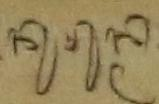
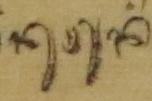
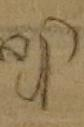
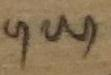
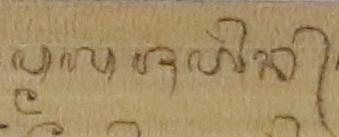
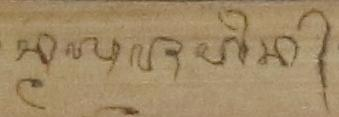
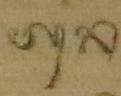
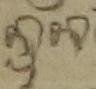
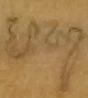
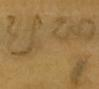
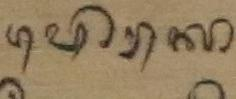
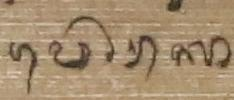
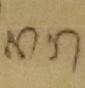
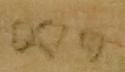
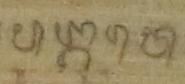
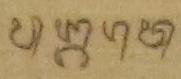
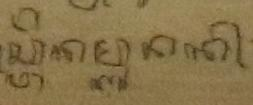
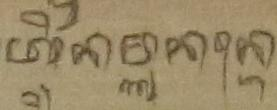
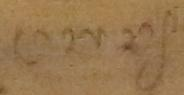
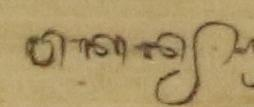

In [13]:
from IPython.display import display, HTML
from PIL import Image
import base64

def encode_image(image_path):
    """
    Converts an image to a base64 encoded string for embedding in an HTML table.
    """
    with open(image_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode("utf-8")

def display_images_in_table(word_list, title, num_examples=3):
    """
    Displays images and their corresponding transliterations in a formatted HTML table.
    """
    print(f"\n {title}")

    html_table = f"""
    <h3>{title}</h3>
    <table border="1" style="border-collapse: collapse; width: 50%;">
        <tr>
            <th style="padding: 8px; text-align: center;">Image</th>
            <th style="padding: 8px; text-align: center;">Transliteration</th>
        </tr>
    """

    for word in word_list:
        subset = train_df[train_df['label'] == word].head(num_examples)
        for _, row in subset.iterrows():
            img_path = os.path.join(image_dir, row['filename'])
            if os.path.exists(img_path):
                img_base64 = encode_image(img_path)
                img_tag = f'<img src="data:image/png;base64,{img_base64}" width="100">'
                html_table += f"""
                <tr>
                    <td style="padding: 8px; text-align: center;">{img_tag}</td>
                    <td style="padding: 8px; text-align: center;">{row['label']}</td>
                </tr>
                """
            else:
                print(f"Missing Image: {img_path}")

    html_table += "</table>"
    display(HTML(html_table))

# Show images for the most frequent words in a table
# top_5_words = label_counts.index[:5]
# display_images_in_table(top_5_words, "Top 5 Frequent Words")

# Show images for least frequent words (if available)
rare_words = label_counts[label_counts < 3].index[:10]
display_images_in_table(rare_words, "Rare Words (Appear <3 Times)")


In [14]:
# Check for missing values
missing_values = train_df.isnull().sum().sum()
duplicates = train_df.duplicated().sum()

if missing_values == 0:
    print("No missing values detected.")
else:
    print(f"Missing values found: {missing_values}")

if duplicates == 0:
    print("No duplicate rows detected.")
else:
    print(f"Duplicate rows found: {duplicates}")


No missing values detected.
No duplicate rows detected.


In [15]:
# Find characters present in testing but NOT in training
test_extra_chars = test_chars - train_chars
if test_extra_chars:
    print("\n Characters in Testing but NOT in Training:")
    print(" ".join(sorted(test_extra_chars)))
else:
    print("\n No new characters in testing set.")



 Characters in Testing but NOT in Training:
H
